In [ ]:
import h5py
import numpy as np
import math

In [ ]:
filenames =[
"./C1_R1v2_ID1v2.mp4.predictions.000_C1_R1v2_ID1v2.analysis_fixed.h5",
"./C1_R1v4_ID1v3.mp4.predictions.000_C1_R1v4_ID1v3.analysis_fixed.h5",
"./C2_R1v2_ID1v3.mp4.predictions.000_C2_R1v2_ID1v3.analysis_fixed.h5",
"./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5",
"./C3_R2v1_ID3v4.mp4.predictions.000_C3_R2v1_ID3v4.analysis_fixed.h5",
"./C3_R1v4_ID4v1.mp4.predictions.000_C3_R1v4_ID4v1.analysis_fixed.h5",
'./C4_R2v1_ID3v2.mp4.predictions.000_C4_R2v1_ID3v2.analysis_fixed.h5',
"./C4_R1v4_ID2v4.mp4.predictions.000_C4_R1v4_ID2v4.analysis_fixed.h5",
"./C5_R2v1_ID2v4.mp4.predictions.000_C5_R2v1_ID2v4.analysis_fixed.h5",
"./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis_fixed.h5",
"./C6_R1v2_ID1v3.mp4.predictions.slp.000_C6_R1v2_ID1v3.analysis_fixed.h5",
"./C6_R4v1_ID4v1.mp4.predictions.000_C6_R4v1_ID4v1.analysis_fixed.h5"
]

def get_info(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
    return dset_names, locations, node_names

In [ ]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [ ]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [ ]:
node_names

['ear', 'nose', 'tail_base', 'thorax', 'front_foot', 'rear_foot']

In [ ]:
locations = fill_missing(locations)

In [ ]:
print(locations.shape)

(1213, 6, 2, 2)


In [ ]:
len(locations)

1213

In [ ]:
def get_distances_between_mice(locations, node_index):
    #confirmed does what i want it to
    """
    takes in locations and node index 
    returns a list of distances between the nodes of the two mice
    """
    c_list = []
    for i in range(len(locations)):
    
        (x1,y1) = (locations[i,node_index,0,0], locations[i,node_index,1,0])
        # x , y coordinate of nose for mouse 1
        (x2, y2) = (locations[i,node_index,0,1], locations[i,node_index,1,1])
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        a2 = (x1 - x2) ** 2 
        b2 = (y1 - y2) ** 2 
        c = math.sqrt(a2 + b2)
        c_list.append(c)
    return c_list



In [ ]:
thorax_distances = get_distances_between_mice(locations,1)


In [ ]:
def get_distances_between_nodes(locations, node_index1, node_index2):
    # CONFIRMED THAT IT WORKS in terms of doing the math by hand
    """
    takes in locations and node indexes of the two body parts you want 
    within mice distances for 

    returns nested lists, list[0] is the distances within track1
    list[1] is the distances within track2

    """
    c_list = []
    m1_c_list = []
    m2_c_list = []
    for i in range(len(locations)):
        x1,y1 = locations[i, node_index1,0,0], locations[i,node_index1,1,0]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[i,node_index2,0,0], locations[i,node_index2,1,0]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[i,node_index1,0,1], locations[i,node_index1,1,1]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[i,node_index2,0,1], locations[i,node_index2,1,1]
        # solve for c using pythagroean theory
        a2 = (x1 - x2) ** 2 
        b2 = (y1 - y2) ** 2
        a2_m2 = (x3 -x4) ** 2
        b2_m2 = (y3 - y4) ** 2 
        c2 = math.sqrt(a2_m2 + b2_m2)
        c1 = math.sqrt(a2 + b2)
        m1_c_list.append(c1)
        m2_c_list.append(c2)
    c_list.append(m1_c_list)
    c_list.append(m2_c_list)
    return c_list

In [ ]:
ose_to_thorax_distance = get_distances_between_nodes(locations, 1, 4)
print(len(ose_to_thorax_distance[1]))


1213


In [ ]:
def get_velocities(locations, node_index):

    node_loc_1 = locations[:,node_index,:,0]
    # node loc (x,y) of node of mouse 1
    node_loc_2 = locations[:,node_index,:,1]
    # x,y's of node of mouse 2 
    m1_vel = smooth_diff(node_loc_1)
    m2_vel = smooth_diff(node_loc_2)
    velocities = [m1_vel,m2_vel]
    return velocities 

In [ ]:
velocities = get_velocities(locations, 1)
print(len(velocities[1]))

1213


In [ ]:
def get_angles(locations, node_index_1, node_index_2, node_index_3):
    """
    takes in locations and three nodes, calculates angle between the three points 
    with the second node being the center point
    i.e. node_1 = nose , node_2 = ear , node_3 = thorax
    returns [[list of angles for mouse 1][list of angles for mouse 2]]
    """
    angles_all_mice = []
    frame, nodes, axes, mice = locations.shape
    
        
    for mouse in range(mice):
        angles = []
        for i in range(len(locations)):
            a = np.array([locations[i,node_index_1,0,mouse], locations[i,node_index_1, 1, mouse]])
            b = np.array([locations[i,node_index_2,0,mouse], locations[i,node_index_2, 1, mouse]])
            c = np.array([locations[i,node_index_3,0,mouse], locations[i,node_index_3, 1, mouse]])
            ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
            if ang < 0:
                angles.append(ang + 360)
            else: 
                angles.append(ang)
        angles_all_mice.append(angles)
    return angles_all_mice




In [ ]:
angles = get_angles(locations, 0, 1, 4)
print(len(angles[1]))

1213


In [ ]:
test = np.zeros((2,2))
test[0] = [1,2]
print(test[0][1])

2.0


In [ ]:


is_first = True
for filename in filenames: 
    dset_names, locations, node_names = get_info(filename)
    features = np.zeros((9,len(locations)))
    locations = fill_missing(locations)
    angles = get_angles(locations, 0, 1, 3)
    features[0] = angles[0]
    features[1] = angles[1]
    nose_velocities = get_velocities(locations, 1)
    features[2] = nose_velocities[0]
    features[3] = nose_velocities[1]
    thorax_velocities = get_velocities(locations,3)
    features[4] = thorax_velocities[0]
    features[5] = thorax_velocities[1]
    features[6] = get_distances_between_mice(locations, 1)
    nose_tailbase = get_distances_between_nodes(locations, 1,2)
    features[7] = nose_tailbase[0]
    features[8] = nose_tailbase[1]
    print(features.shape)
    if is_first:
        features_total = features
        is_first = False
    else:
        features_total = np.concatenate((features_total, features),1)

features_total = np.swapaxes(features_total,0,1)


(9, 1213)
(9, 206)
(9, 775)
(9, 144)
(9, 773)
(9, 277)
(9, 407)
(9, 59)
(9, 415)
(9, 57)
(9, 479)
(9, 92)


In [ ]:
features_total.shape

(4897, 9)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from scipy.stats import linregress
from scipy.optimize import curve_fit

In [ ]:

import os
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import sklearn.cluster as cluster

In [ ]:
reducer = umap.UMAP()
# dimenionality reduction part of UMAP ( uniform manifold approximation & projection )

standard_embedding = reducer.fit_transform(features_total)


In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors= 18,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(features_total)

clusterable_embedding.shape

(4897, 2)

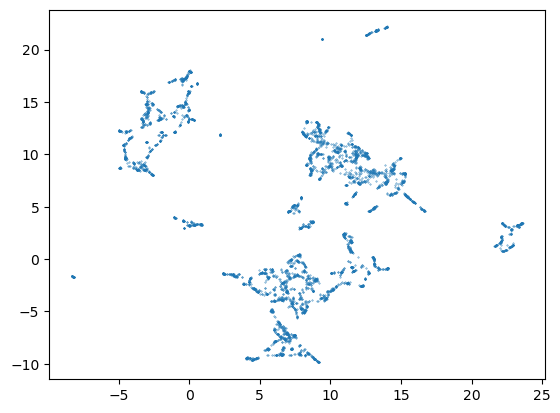

In [ ]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1,)

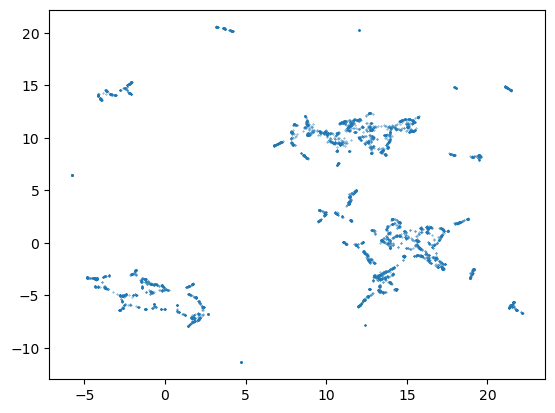

In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(clusterable_embedding)
print(hdbscan_labels[4896])
print(hdbscan_labels[3])
print(hdbscan_labels[560])


print(np.unique(hdbscan_labels))
print(type(hdbscan_labels))
print(len(hdbscan_labels))

1
1
2
[-1  0  1  2]
<class 'numpy.ndarray'>
4897


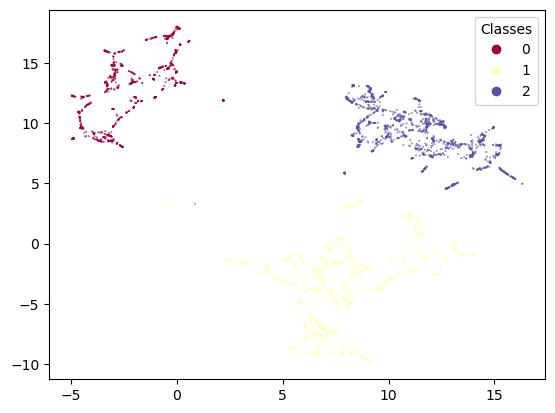

In [ ]:
clustered = (hdbscan_labels >= 0)
fig, ax = plt.subplots()

# plt.scatter(standard_embedding[~clustered, 0],
#             standard_embedding[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=0.1,
#             alpha=0.5)
scatter = plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral')

plt.legend(*scatter.legend_elements(),  title="Classes")
plt.savefig('./feature_clusters.png')
plt.show()


In [ ]:
from moviepy.editor import *
final_vid = VideoFileClip("final_final.mp4")
n_frames = final_vid.reader.nframes

In [ ]:
def cluster_dic(labels):
    """
    takes in a list of labels (hdbscan labels)
    and returns a dictionary {cluster:[list of frames]}
    """
    clusters = {}
    print(labels)
    # if a cluster key already exists in the dictionary, append its value (list) with the new frame (i)
    for i in range(len(labels)):
        if labels[i] in clusters:
            temp_val = clusters[labels[i]]
            temp_val.append(i)
            clusters[labels[i]] = temp_val
        #if the cluser does not have a unique key yet, create one, who 
        else:
            clusters[labels[i]] = [i]
    return clusters

cluster_dict = cluster_dic(hdbscan_labels)

[1 1 1 ... 1 1 1]


In [ ]:
import moviepy.editor as mpy

def make_clip(list_of_frames, video):
    frames = []
    for frame in list_of_frames:
        frames.append(video.get_frame(frame/30))

    clip = mpy.ImageSequenceClip(frames, fps=30)
    return clip

small_example = cluster_dict[1]
cluster_2 = cluster_dict[0]
cluster_3 = cluster_dict[2]
cluster_1 = make_clip(small_example, final_vid)
cluster_1.write_videofile('cluster1.mp4')
cluster_2_vid = make_clip(cluster_2, final_vid)
cluster_3_vid = make_clip(cluster_3, final_vid)
cluster_2_vid.write_videofile('cluster2.mp4')
cluster_3_vid.write_videofile('cluster3.mp4')


Moviepy - Building video cluster1.mp4.
Moviepy - Writing video cluster1.mp4



Moviepy - Done !
Moviepy - video ready cluster1.mp4
